Healthcare is an extremely important part of the technological revolution, with deep learning techniques being applied to more and more medical problems. 

This dataset for the detection of pneumonia, using chest x-ray images (https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) is used for binary classification (whether the person is normal or has pneumonia). 

This notebook was executed in a Google Colab environment, and used transfer learning from a ResNet50 architecture, and after just 10 epochs of training, I was able to achieve **>80% accuracy**. Some minor tweaks and additional architectural changes can definitely increase the accuracy to close to 90% and maybe, even beyond that. 

Using this very simple code, we can use the Kaggle API to download the dataset into our environment. 


In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "##########" # username from the json file
os.environ['KAGGLE_KEY'] = "###################" # key from the json file
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:30<00:00, 24.3MB/s]
100% 2.29G/2.29G [00:30<00:00, 80.1MB/s]


Next, the file has to be unzipped (it is in zip format) and the directories are specified for the train, test and validation sets, as well as the normal and pneumonia directories for the train and validation sets.

In [0]:
import zipfile
local_zip = '/content/chest-xray-pneumonia.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [0]:
base_dir = '/content/chest_xray'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [0]:
train_normal_dir = os.path.join(train_dir,'NORMAL')
train_pneu_dir = os.path.join(train_dir,'PNEUMONIA')
validation_normal_dir = os.path.join(validation_dir,'NORMAL')
validation_pneu_dir = os.path.join(validation_dir,'PNEUMONIA')

In [5]:
print('total training normal images:', len(os.listdir(train_normal_dir)))
print('total training pneu images:', len(os.listdir(train_pneu_dir)))

total training normal images: 1341
total training pneu images: 3875


There are 1341 normal images and 3875 pneumonia images in the training set, which seems to be more than sufficient. 

In [0]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

We specify a constant image size to make things uniform for the model to input. We then input the ResNet50 architecture, and ensure it cannot be trained, and that we retain all the weights. 

In [14]:
img_size=[224,224]
model=tf.keras.applications.resnet50.ResNet50(input_shape=img_size + [3], weights='imagenet', include_top=False)
model.trainable = False

94773248/94765736 [==============================] - 1s 0us/step


The last layer of the architecture is the 'conv5_block3_out', with a shape of (7,7,2048) which we will use later.

In [16]:
last_layer = model.get_layer('conv5_block3_out')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 2048)


We then specify 2 last layers, a dense layer with 1024 nodes, with a 20% dropout rate to prevent overfitting, as well as a final dense layer with a single node and a sigmoid activation (which outputs 0 or 1 to classify)

In [0]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1, activation='sigmoid')(x)           

In [0]:
amodel=Model(model.input,x) 

The layers of our new model (amodel) and their shapes can be seen using the summary() function. 

In [24]:
amodel.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
from tensorflow.keras.optimizers import RMSprop
amodel.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

Compiling the model using RMSProp as the optimizer and a binary_crossentropy loss because of the 2 classes.


---

Next, we use the ImageDataGenerator function in keras to import the images and perform some augmentation on them, as well as to specify some arguments. 

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (224, 224))     

validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (224, 224))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


There are 5216 training images and 16 validation images. 

All that's left is to run the model for just 10 epochs. 

In [28]:
history = amodel.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 10,
            validation_steps = 50,
            verbose = 2)

Epoch 1/10
100/100 - 47s - loss: 0.8222 - accuracy: 0.6995 - val_loss: 0.6554 - val_accuracy: 0.5625
Epoch 2/10
100/100 - 45s - loss: 0.5184 - accuracy: 0.7490 - val_loss: 0.6276 - val_accuracy: 0.6250
Epoch 3/10
100/100 - 46s - loss: 0.4954 - accuracy: 0.7555 - val_loss: 0.7007 - val_accuracy: 0.5625
Epoch 4/10
100/100 - 46s - loss: 0.4552 - accuracy: 0.7710 - val_loss: 0.9272 - val_accuracy: 0.5625
Epoch 5/10
100/100 - 45s - loss: 0.4410 - accuracy: 0.7835 - val_loss: 0.9437 - val_accuracy: 0.5625
Epoch 6/10
100/100 - 45s - loss: 0.4338 - accuracy: 0.7871 - val_loss: 0.5694 - val_accuracy: 0.6250
Epoch 7/10
100/100 - 45s - loss: 0.4113 - accuracy: 0.7920 - val_loss: 0.9337 - val_accuracy: 0.5625
Epoch 8/10
100/100 - 45s - loss: 0.4150 - accuracy: 0.8001 - val_loss: 0.9175 - val_accuracy: 0.5625
Epoch 9/10
100/100 - 45s - loss: 0.4003 - accuracy: 0.8055 - val_loss: 0.7112 - val_accuracy: 0.6875
Epoch 10/10
100/100 - 46s - loss: 0.3825 - accuracy: 0.8155 - val_loss: 0.6212 - val_accura

We get 81% accuracy after 10 epochs. Validation accuracy is around 62%. Other architectures such as VGG16 or VGG19 can also be used, and may increase the accuracy. 



---

We can plot the training and validation accuracy and see how training occurred. 

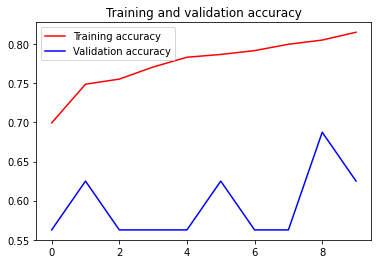

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

Training accuracy seems to be steadily increasing, but validation accuracy seems to have peaks and valleys, but overall it does increase. This might be a sign of some overfitting, but definitely not a large amount of overfitting. 